In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")


from scipy.signal import correlate

from tqdm.notebook import tqdm

import h5py

import matplotlib.pyplot as plt
import pyseistr as ps
from pyseistr import cseis as seis

import sys
sys.path.append("..")
import models
import data
import inference

%load_ext autoreload
%autoreload 2

In [2]:
dx = 4

nx = 32
nx_width = 4
nx_stride = 3
if dx == 4:
    nx = 128
    nx_width = 16
    nx_stride = 12
nt = 512

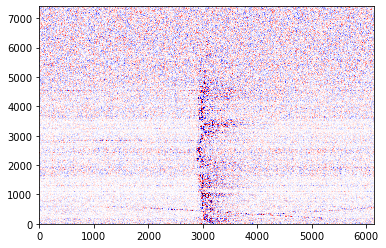

In [3]:
fs = 50.0

file = '../data/preprocessed/real_test/2023p273854.h5'
idx = 5500

with h5py.File(file, 'r') as hf:
    samples = hf['DAS'][81:,idx-3072:idx+3072]

if dx == 20:
    samples = samples[::5]

gutter = 1000
x = np.pad(samples[None,:], ((0,0),(0,0),(gutter,gutter)), mode='constant', constant_values=0)
x = data.bandpass(x, low=1.0, high=10.0, fs=fs, gutter=gutter)[0]
x = x / x.std(axis=-1, keepdims=True)
np.save('../data/2023p273854_input{}.npy'.format(dx), x)

plt.imshow(x, origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=-1, vmax=1)

# IDF
https://github.com/aaspip/pyseistr/blob/main/demos/test_pyseistr_das.py

In [4]:
x = np.load('../data/2023p273854_input4.npy')
dn = x[300:812,2700:3212]

print(dn.max())
d1 = ps.bandpassc(dn, 0.0005, 0, 200, 6, 6, 0, 0)
d1_bp = d1.copy()
print(d1.max())

## SOMF
pp = ps.dip2dc(d1, 2, 10, 2, 0.01, 1, 0.000001, [50,50,1], 1)
print('finished')
d1 = ps.somf2dc(d1, pp, 8, 2, 0.01, 1) #SOMF
d1_bpsomf = d1.copy()

## FK
d1 = d1_bpsomf - ps.fkdip(d1, 0.02)
d1_bpsomffk = d1.copy()

26.369321201755003
21.526237
finished


# DIP
https://github.com/DmitryUlyanov/deep-image-prior/blob/master/denoising.ipynb

In [5]:
import dip
from skimage.metrics import peak_signal_noise_ratio

In [6]:
img_noisy_np = np.load('../data/2023p273854_input4.npy')

imin = img_noisy_np.min()
imax = img_noisy_np.max()

img_noisy_np = np.tile(img_noisy_np[300:812,2700:3212], (3,1,1))

img_noisy_np = (img_noisy_np - imin) / (imax - imin)

INPUT = 'noise'
pad = 'reflection'
OPT_OVER = 'net'

reg_noise_std = 1./30.
LR = 0.01

OPTIMIZER='adam'
show_every = 100
exp_weight = 0.99

num_iter = 3000
input_depth = 32 
figsize = 4 

net = dip.skip(input_depth, 3, num_channels_down = [128]*5,
               num_channels_up = [128]*5,
               num_channels_skip = [4]*5, 
               upsample_mode='bilinear', downsample_mode='stride',
               need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(torch.cuda.FloatTensor)
    
net_input = dip.get_noise(input_depth, INPUT, (512, 512)).type(torch.cuda.FloatTensor).detach()

# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(torch.cuda.FloatTensor)

img_noisy_torch = dip.np_to_torch(img_noisy_np).type(torch.cuda.FloatTensor)

Number of params: 2217831


In [7]:
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
out_avg = None
last_net = None
psrn_noisy_last = 0

i = 0
def closure():
    
    global i, out_avg, psrn_noisy_last, last_net, net_input
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    
    out = net(net_input)
    
    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)
            
    total_loss = mse(out, img_noisy_torch)
    total_loss.backward()
    
    psrn_noisy = peak_signal_noise_ratio(img_noisy_np, out.detach().cpu().numpy()[0]) 
    
    # Note that we do not have GT for the "snail" example
    # So 'PSRN_gt', 'PSNR_gt_sm' make no sense
    print ('Iteration %05d    Loss %f   PSNR_noisy: %f' % (i, total_loss.item(), psrn_noisy), '\r', end='')
    
    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5: 
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy
            
    i += 1

    return total_loss

p = dip.get_params(OPT_OVER, net, net_input)
dip.optimize(OPTIMIZER, p, closure, LR, num_iter)
out_np = dip.torch_to_np(net(net_input))
out_dip = (out_np * (imax - imin) + imin)[0]

Starting optimization with ADAM


/tmp/ipykernel_2025934/2079643089.py:26: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psrn_noisy = peak_signal_noise_ratio(img_noisy_np, out.detach().cpu().numpy()[0])


In [8]:
# Calculate CN2S reconstruction

if not os.path.isfile('../data/2023p273854_CN2S4.npy'):

    model = models.CN2SUNet(1, 1, hidden_ch=32, n_layers=4).to(device)
    model.load_state_dict(torch.load('../ckpt/CN2S-finetuned{}-complement-{}x{}-{}x180_200.pt'.format(4, 128, 512, 16)))
    model.eval()
    
    x = np.load('../data/2023p273854_input4.npy')
    rec = inference.xreconstruct(model, torch.from_numpy(x).to(device), nx, nt, nx_width, nx_stride=nx_width//2, nt_stride=180//2, batch_size=128, dx=4, verbose=False)
    rec_filt = np.pad(rec.cpu().numpy()[None,:], ((0,0),(0,0),(gutter,gutter)), mode='constant', constant_values=0)
    rec_filt = data.bandpass(rec_filt, low=1.0, high=10.0, fs=fs, gutter=gutter)[0]

    np.save('../data/2023p273854_CN2S4.npy', rec_filt)
    
# Calculate N2S reconstruction

if not os.path.isfile('../data/2023p273854_N2S4.npy'):

    model = models.N2SUNet(1, 1, 4).to(device)
    model.load_state_dict(torch.load('../ckpt/N2S-finetuned{}-{}x2048-{}x2048_200.pt'.format(dx, 11 + 3*11* (dx == 4), 1 + 3* (dx == 4))))
    model.eval()
    if dx == 20:
        rec = inference.channelwise_reconstruct(model, torch.from_numpy(x).to(device), nx=11, nt=2048)
    else:
        rec = inference.xreconstruct(model, torch.from_numpy(x).to(device), 44, 2048, 4, nx_stride=4, nt_stride=512, batch_size=128, dx=4, verbose=False, ende=True)
    rec_filt = np.pad(rec.cpu().numpy()[None,:], ((0,0),(0,0),(gutter,gutter)), mode='constant', constant_values=0)
    rec_filt = data.bandpass(rec_filt, low=1.0, high=10.0, fs=fs, gutter=gutter)[0]

    np.save('../data/2023p273854_N2S4.npy', rec_filt)

In [9]:
x = np.load('../data/2023p273854_input4.npy')[300:812,2700:3212]
n2s = np.load('../data/2023p273854_N2S4.npy')[300:812,2700:3212]
cn2s = np.load('../data/2023p273854_CN2S4.npy')[300:812,2700:3212]

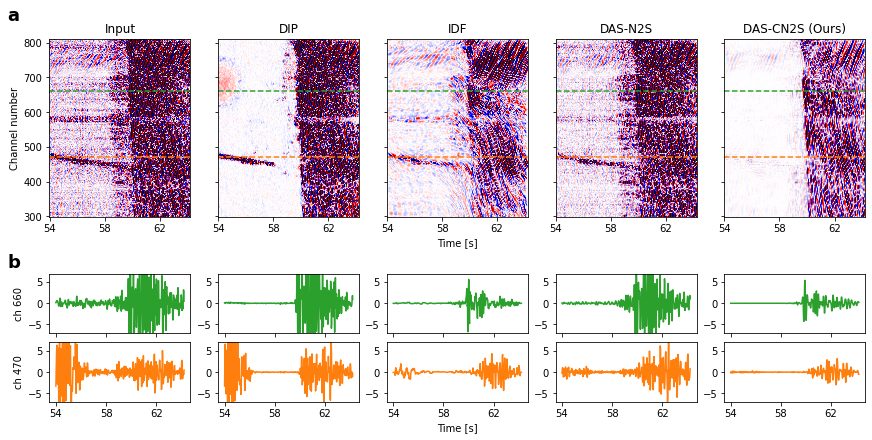

In [10]:
fig, axs = plt.subplot_mosaic([['a','a','a','b','b','b','c','c','c','d','d','d','e','e','e',],
                               ['a','a','a','b','b','b','c','c','c','d','d','d','e','e','e',],
                               ['a','a','a','b','b','b','c','c','c','d','d','d','e','e','e',],
                               ['a1', 'a1', 'a1', 'b1', 'b1', 'b1', 'c1', 'c1', 'c1','d1','d1','d1','e1','e1','e1',],
                               ['a2', 'a2', 'a2', 'b2', 'b2', 'b2', 'c2', 'c2', 'c2','d2','d2','d2','e2','e2','e2',]],
                              layout='constrained', figsize=(12,6))

v = 1
axs['a'].imshow(x, origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=-v, vmax=v)
axs['a'].yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int((x + 300))}')) 
axs['b'].imshow(out_dip, origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=-v, vmax=v)
axs['c'].imshow(d1_bpsomffk, origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=-v, vmax=v)
axs['d'].imshow(n2s, origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=-v, vmax=v)
axs['e'].imshow(cn2s, origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=-v, vmax=v)

ch1 = 360
ch2 = 170

for s in ['a', 'b', 'c', 'd', 'e']:
    axs[s].axhline(ch1, ls="--", c="tab:green")
    axs[s].axhline(ch2, ls="--", c="tab:orange")
    
axs['a1'].plot(x[ch1], color='tab:green')
axs['a2'].plot(x[ch2], color='tab:orange')
axs['b1'].plot(out_dip[ch1], color='tab:green')
axs['b2'].plot(out_dip[ch2], color='tab:orange')
axs['c1'].plot(d1_bpsomffk[ch1], color='tab:green')
axs['c2'].plot(d1_bpsomffk[ch2], color='tab:orange')

axs['d1'].plot(n2s[ch1], color='tab:green')
axs['d2'].plot(n2s[ch2], color='tab:orange')
axs['e1'].plot(cn2s[ch1], color='tab:green')
axs['e2'].plot(cn2s[ch2], color='tab:orange')

axs['a1'].set_ylabel("ch {}".format(ch1+300))
axs['a2'].set_ylabel("ch {}".format(ch2+300))

for s in ['a', 'b', 'c', 'd', 'e', 'a1', 'b1', 'c1', 'd1', 'e1', 'a2', 'b2', 'c2', 'd2', 'e2']:
    axs[s].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(((x + 2700) / 50))}'))
for s in ['a1', 'b1', 'c1', 'd1', 'e1']:
    axs[s].set_xticklabels([])
#for s in ['b1', 'b2', 'b3', 'c1', 'c2', 'c3', 'd1', 'd2', 'd3']:
#    axs[s].set_yticklabels([])    

for s in ['a1', 'a2']:
    axs[s].set_ylim((-7,7))
for s in ['b1', 'b2']:
    axs[s].set_ylim((-7,7))
for s in ['c1', 'c2']:
    axs[s].set_ylim((-7,7))
for s in ['d1', 'd2']:
    axs[s].set_ylim((-7,7))
for s in ['e1', 'e2']:
    axs[s].set_ylim((-7,7))

axs['a'].set_ylabel('Channel number')


axs['b'].set_yticklabels([])
axs['c'].set_yticklabels([])
axs['d'].set_yticklabels([])
axs['e'].set_yticklabels([])

axs['a'].set_title('Input')
axs['b'].set_title('DIP')
axs['c'].set_title('IDF')
axs['d'].set_title('DAS-N2S')
axs['e'].set_title('DAS-CN2S (Ours)')


axs['a'].text(-0.3, 1.1, 'a', transform=axs['a'].transAxes, size=18, weight='bold')
axs['a1'].text(-0.3, 1.1, 'b', transform=axs['a1'].transAxes, size=18, weight='bold')

axs['c'].set_xlabel('Time [s]')
axs['c2'].set_xlabel('Time [s]')

#fig.text(0.525, 0.395, 'Time [s]', ha='center', va='center', fontsize=10)
#fig.text(0.525, -0.005, 'Time [s]', ha='center', va='center', fontsize=10)

plt.savefig('./out/figure_12.pdf', bbox_inches='tight', dpi=200)
plt.show()